In [6]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm
print(pp.__version__)
import matplotlib.pyplot as plt
import ruptures as rpt
from tqdm import tqdm
# from julia.PowerModels import run_ac_opf
# from julia.PowerModels import run_ac_opf

2.0.1


In [7]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'i':
                    mu =net.res_trafo.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='i':
                    mu =net.res_trafo.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

In [8]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.01
lower_bus_accuracy=0.99
upper_line_accuracy=1.03
lower_line_accuracy=0.97
upper_trafo_accuracy=1.03
lower_trafo_accuracy=0.97


#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)


scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

In [90]:
list_PV_loc=[]
list_PV_value=[]
list_PV_detected_loc=[]
list_PV_detected_value_1=[]
list_PV_detected_value_2=[]
list_PV_detected_value_3=[]


for round in tqdm(range(1), desc='round: '):    
    net = pn.case14()
    net.bus=net.bus.sort_index()
    net.line=net.line.sort_index()
    net.trafo=net.trafo.sort_index()
    net.load=net.load.sort_index()
    net.gen=net.gen.sort_index()
    # net.shunt=net.shunt.sort_index()
    net.gen.p_mw=net.gen.max_p_mw

    p_mw=np.array([[0 for item in range(len(net.bus))]])

    zero_inject_bus= list(set(net.bus.index).difference(set(np.where(net.gen.p_mw!=0)[0]).union(set(net.load.bus)).union(net.ext_grid.bus).union(net.shunt.bus)))
    list_bus_meas=list(set(net.bus.index)-set(zero_inject_bus))
    list_line_meas=list(set(net.line.index))
    list_transfo_meas=list(set(net.trafo.index))
    df_measurement=pd.DataFrame()
    df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','p','q']*len(list_line_meas)+['p','q','p','q']*len(list_transfo_meas)
    df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line','line']*len(list_line_meas)+['trafo','trafo','trafo','trafo']*len(list_transfo_meas)
    df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(4)]+[item for item in list_transfo_meas for x in range(4)]
    df_measurement['side']=['None']*len(list_bus_meas)+['from','from','to','to']*len(list_line_meas)+['from','from','to','to']*len(list_transfo_meas)

    p_mw=np.array([np.zeros(len(net.bus))])
    pv_location=np.random.randint(2, size=len(net.gen))
    print(pv_location)

    for scaling_solar, load_scalng in zip(scaling_for_solar[0],scaling_for_load[0]):
        net.gen.scaling=scaling_solar*pv_location
        net.load.scaling[:]=load_scaling
        pp.runpp(net)
        net.res_bus=net.res_bus.sort_index()
        net.res_line=net.res_line.sort_index()
        net.res_trafo=net.res_trafo.sort_index()
        df_measurement, net = create_measurement_unit(df_measurement, net)
        success = estimate(net, init="slack", zero_injection=zero_inject_bus, calculate_voltage_angles=True)
        new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
        p_mw=np.concatenate((p_mw, new_mw), axis=0)

    df=pd.DataFrame()
    # df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
    df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
    bus_has_solar_PV=[]
    list_corr=[]
    for bus in range(0,len(p_mw[0])):
    #     df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
        df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
        corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
        print('correlation at bus {} is: {}'.format(bus, corr))
        list_corr.append(corr)
        if corr < 0:
            bus_has_solar_PV.append(bus)
    bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,2,13,14]]
    list_PV_detected_loc.append(bus_has_solar_PV)
    #combine solar scaling and p_mw at solar located bus
    new_p_mw=p_mw.copy()
    new_p_mw=new_p_mw.transpose()
    my_array=np.array([scaling_for_solar[0]]).T.copy()
    for located_bus in bus_has_solar_PV:
        my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

    index=list(set(np.argwhere(np.isnan(my_array))[:,0]))
    if (len(index)>0):
        print('there is NaN in array')
        my_array=np.delete(my_array, index, axis=0)

    algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
    my_bkps = algo.predict(pen=1)
    # display
#     rpt.display(my_array, my_bkps)
#     plt.show()
    size_pv_1=[]
    size_pv_2=[]
    size_pv_3=[]
    for bus in bus_has_solar_PV:
        sum_value=np.array([])
        for period in my_bkps[:-1]:
            value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
            if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
                sum_value = np.append(sum_value, value)
#             print(sum_value)
        size_pv_1.append(sum_value.sum()/len(sum_value))
#         print('bus :', bus, 'has solar PV size: ', size_pv_1)
        size_pv_2.append(sum_value.sum()/len(sum_value)*list_corr[bus])
#         print('bus :', bus, 'has solar PV size: ', size_pv_2)
        mean = np.mean(sum_value, axis=0)
        sd = np.std(sum_value, axis=0)
        final_list = [x for x in sum_value if (x > mean - 2 * sd)]
        final_list = [x for x in final_list if (x < mean + 2 * sd)]
#         print(final_list)
        size_pv_3.append(np.array(final_list).mean()*list_corr[bus])
        print('bus :', bus, 'has solar PV size: ', size_pv_3)
    list_PV_detected_value_1.append(size_pv_1)
    list_PV_detected_value_2.append(size_pv_2)
    list_PV_detected_value_3.append(size_pv_3)
    
    



round:   0%|          | 0/1 [00:00<?, ?it/s]

[0 0 1 1]


/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/lin

KeyboardInterrupt: 

In [74]:
bus_has_solar_PV=[]
list_corr=[]
for bus in range(0,len(p_mw[0])):
#     df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    list_corr.append(corr)
    if corr < 0:
        bus_has_solar_PV.append(bus)
bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,2,13,14]]

list_PV_detected_loc.append(bus_has_solar_PV)
#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
my_array=np.array([scaling_for_solar[0]]).T.copy()
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

index=list(set(np.argwhere(np.isnan(my_array))[:,0]))
new_array=np.delete(my_array.copy(), index, axis=0)

algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(new_array[:])
my_bkps = algo.predict(pen=1)
# display
#     rpt.display(my_array, my_bkps)
#     plt.show()
size_pv_1=[]
size_pv_2=[]
size_pv_3=[]
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
            sum_value = np.append(sum_value, value)
#             print(sum_value)
    size_pv_1.append(sum_value.sum()/len(sum_value))
#         print('bus :', bus, 'has solar PV size: ', size_pv_1)
    size_pv_2.append(sum_value.sum()/len(sum_value)*list_corr[bus])
#         print('bus :', bus, 'has solar PV size: ', size_pv_2)
    mean = np.mean(sum_value, axis=0)
    sd = np.std(sum_value, axis=0)
    final_list = [x for x in sum_value if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
#         print(final_list)
    size_pv_3.append(np.array(final_list).mean()*list_corr[bus])
    print('bus :', bus, 'has solar PV size: ', size_pv_3)
list_PV_detected_value_1.append(size_pv_1)
list_PV_detected_value_2.append(size_pv_2)
list_PV_detected_value_3.append(size_pv_3)

correlation at bus 0 is: -0.05610182852942836
correlation at bus 1 is: -0.05610182852942828
correlation at bus 2 is: -0.05610182852942838
correlation at bus 3 is: 0.05610182852942831
correlation at bus 4 is: -0.056101828529428126
correlation at bus 5 is: -0.056101828529428265
correlation at bus 6 is: 0.05610182852942838
correlation at bus 7 is: -0.05610182852942817
correlation at bus 8 is: -0.056101828529428355
correlation at bus 9 is: -0.056101828529428355
correlation at bus 10 is: -0.05610182852942822
correlation at bus 11 is: 0.05610182852942824
correlation at bus 12 is: -0.05610182852942821
correlation at bus 13 is: -0.05610182852942847
bus : 1 has solar PV size:  [-0.08359659820031086]
bus : 4 has solar PV size:  [-0.08359659820031086, -196.40857106122692]
bus : 5 has solar PV size:  [-0.08359659820031086, -196.40857106122692, 196.57662929114298]
bus : 7 has solar PV size:  [-0.08359659820031086, -196.40857106122692, 196.57662929114298, 0.001808846771330688]
bus : 8 has solar PV s

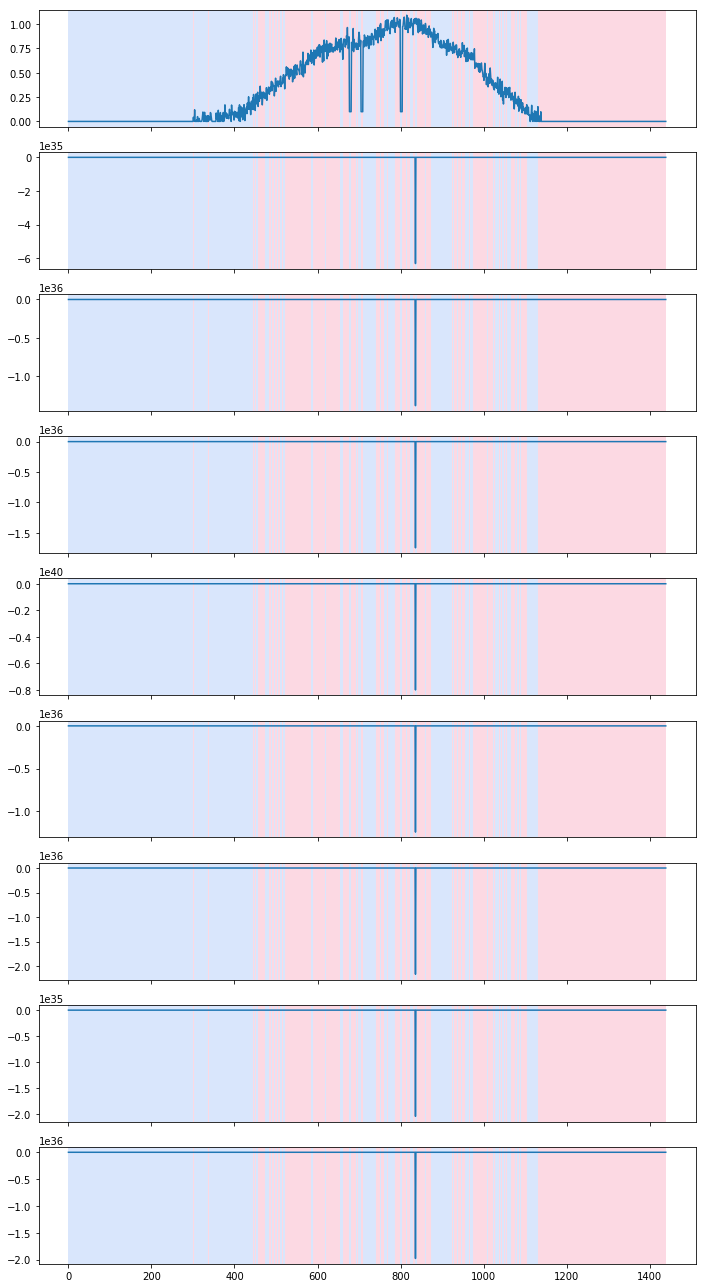

In [88]:
rpt.display(my_array, my_bkps)
plt.show()

In [76]:
bus_has_solar_PV=[]
list_corr=[]
for bus in range(0,len(p_mw[0])):
#     df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    list_corr.append(corr)
    if corr < 0:
        bus_has_solar_PV.append(bus)
bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,2,13,14]]

list_PV_detected_loc.append(bus_has_solar_PV)
#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
my_array=np.array([scaling_for_solar[0]]).T.copy()
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)



correlation at bus 0 is: -0.05610182852942836
correlation at bus 1 is: -0.05610182852942828
correlation at bus 2 is: -0.05610182852942838
correlation at bus 3 is: 0.05610182852942831
correlation at bus 4 is: -0.056101828529428126
correlation at bus 5 is: -0.056101828529428265
correlation at bus 6 is: 0.05610182852942838
correlation at bus 7 is: -0.05610182852942817
correlation at bus 8 is: -0.056101828529428355
correlation at bus 9 is: -0.056101828529428355
correlation at bus 10 is: -0.05610182852942822
correlation at bus 11 is: 0.05610182852942824
correlation at bus 12 is: -0.05610182852942821
correlation at bus 13 is: -0.05610182852942847


In [81]:
len(my_array[0])

9

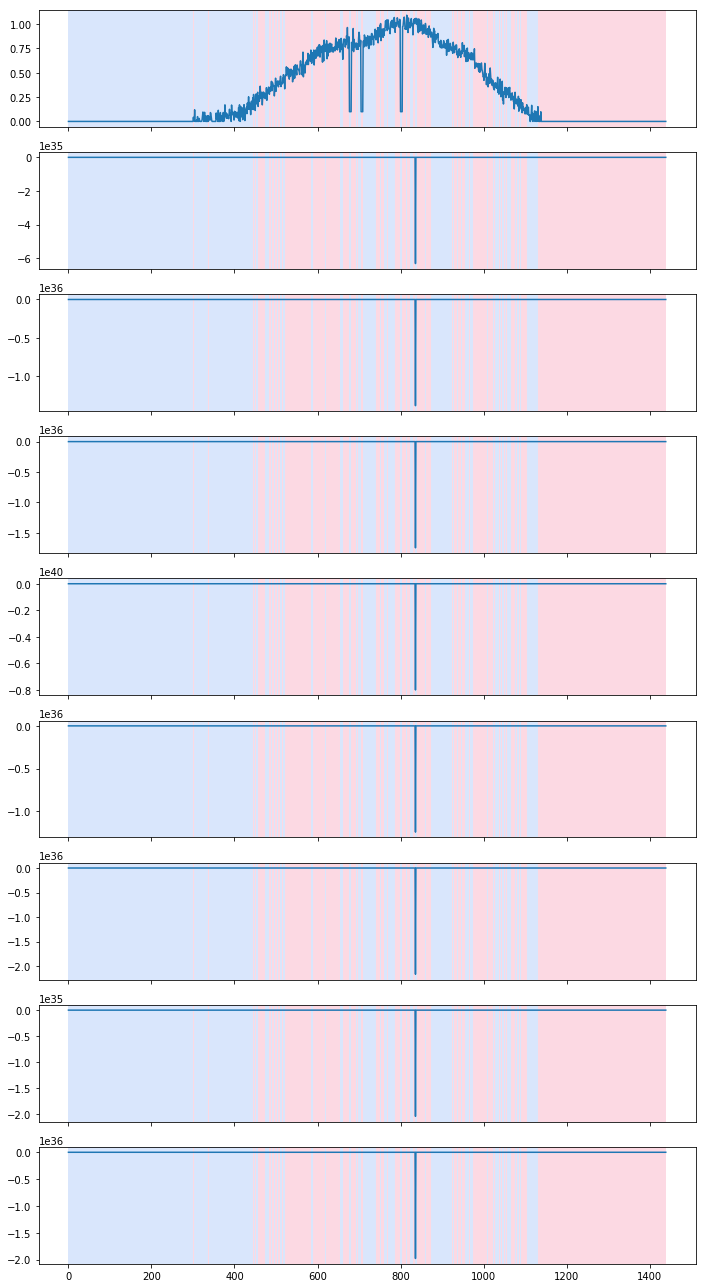

In [82]:
index=list(set(np.argwhere(np.isnan(my_array))[:,0]))
new_array=np.delete(my_array, index, axis=0)

algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(new_array[:])
my_bkps = algo.predict(pen=1)
# display
rpt.display(new_array, my_bkps)
plt.show()

In [86]:
np.argwhere(np.isnan(my_array))

array([], shape=(0, 2), dtype=int64)

In [ ]:
# list_PV_loc=[]
# list_PV_value=[]
# list_PV_detected_loc=[]
# list_PV_detected_value_1=[]
# list_PV_detected_value_2=[]
# list_PV_detected_value_3=[]


# for round in tqdm(range(3), desc='round: '):
#     p_mw=np.array([[0,0,0,0]])
    
#     pv_location=np.zeros(2, dtype='int')
#     while sum(pv_location) == 0:
#         pv_location=np.random.randint(2, size=2) 
# #     pv_location=np.array([1,1])
#     print(pv_location)#     
#     list_PV_loc.append(pv_location)
#     net = pn.simple_four_bus_system()
#     net.sgen.p_mw=np.random.randint(50, size=2)/1000
#     list_PV_value.append(np.array(net.sgen.p_mw[:]))
#     print(net.sgen.p_mw)
#     net.sgen.q_mvar[:]=0
#     for scaling_solar, load_scaling in zip(scaling_for_solar[0],scaling_for_load[0]):
#         net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
#         net.load.scaling=[load_scaling, load_scaling]
#         pp.runpp(net)
#         df_measurement=pd.DataFrame()
#         df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
#         df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
#         df_measurement['element']=[2,3,0,1,0,1,0,1]
#         df_measurement['side']=['None','None','from','from','from','from','from','from']
#         df_measurement, net = create_measurement_unit(df_measurement, net)
#         success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
#         new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
#         p_mw=np.concatenate((p_mw, new_mw), axis=0)

#     df=pd.DataFrame()
#     df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
#     bus_has_solar_PV=[]
#     list_corr=[]
#     for bus in range(0,len(p_mw[0])):
#         df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
#         corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
#         list_corr.append(corr)
# #         print('correlation at bus {} is: {}'.format(bus, corr))
#         if corr <-0.2:
#             bus_has_solar_PV.append(bus)
#     list_PV_detected_loc.append(bus_has_solar_PV)
#     #combine solar scaling and p_mw at solar located bus
#     new_p_mw=p_mw.copy()
#     new_p_mw=new_p_mw.transpose()
#     my_array=np.array([scaling_for_solar[0]]).T.copy()
#     for located_bus in bus_has_solar_PV:
#         my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

#     algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
#     my_bkps = algo.predict(pen=1)
#     # display
# #     rpt.display(my_array, my_bkps)
# #     plt.show()
#     size_pv_1=[]
#     size_pv_2=[]
#     size_pv_3=[]
#     for bus in bus_has_solar_PV:
#         sum_value=np.array([])
#         for period in my_bkps[:-1]:
#             value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
#             if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
#                 sum_value = np.append(sum_value, value)
# #             print(sum_value)
#         size_pv_1.append(sum_value.sum()/len(sum_value))
# #         print('bus :', bus, 'has solar PV size: ', size_pv_1)
#         size_pv_2.append(sum_value.sum()/len(sum_value)*list_corr[bus])
# #         print('bus :', bus, 'has solar PV size: ', size_pv_2)
#         mean = np.mean(sum_value, axis=0)
#         sd = np.std(sum_value, axis=0)
#         final_list = [x for x in sum_value if (x > mean - 2 * sd)]
#         final_list = [x for x in final_list if (x < mean + 2 * sd)]
# #         print(final_list)
#         size_pv_3.append(np.array(final_list).mean()*list_corr[bus])
#         print('bus :', bus, 'has solar PV size: ', size_pv_3)
#     list_PV_detected_value_1.append(size_pv_1)
#     list_PV_detected_value_2.append(size_pv_2)
#     list_PV_detected_value_3.append(size_pv_3)
    
    